In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from pathlib import Path
import numpy as np
from sklearn import preprocessing
import IPython


In [2]:
train_csv = './Dataset/Train.csv'
test_csv = './Dataset/Test.csv'

In [3]:
train_dataset = pd.read_csv(train_csv)
test_dataset = pd.read_csv(test_csv)

In [4]:
train_dataset

,New,Classification
0,1725_.wav,Major
1,1659_.wav,Minor
2,2029_.wav,Major
3,2093_.wav,Minor
4,1661_.wav,Major
...,...,...
673,1567_.wav,Major
674,2265_.wav,Minor
675,1799_.wav,Minor
676,1780_.wav,Minor


Major    386
Minor    292
Name: Classification, dtype: int64


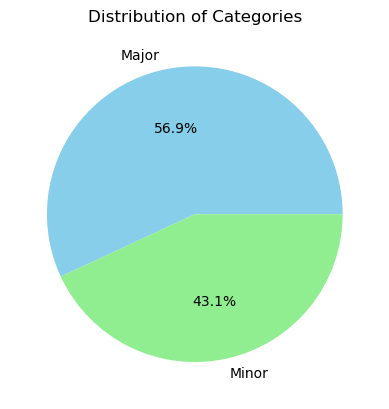

In [5]:
counts =train_dataset['Classification'].value_counts()
print(counts)
# Plot value counts as pie chart
counts. plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Categories')
plt.ylabel('')
plt.show()

In [7]:
def get_log_mel_spectrogram(file_path, target_duration=3, n_mels=128, hop_length=512, fmax=8000, padding_mode='constant'):
    """
    Load an audio file, pad/trim it to a fixed duration, and compute the Log-Mel Spectrogram.

    Parameters:
    - file_path (str): Path to the audio file.
    - target_duration (float): Fixed duration for the spectrogram (in seconds).
    - n_mels (int): Number of Mel bands.
    - hop_length (int): Hop length for STFT.
    - fmax (int): Maximum frequency for Mel scale.
    - padding_mode (str): Padding type ('constant', 'edge', 'reflect').

    Returns:
    - log_mel_spec (np.ndarray): Log-Mel Spectrogram.
    - sr (int): Sample rate.
    """

    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Compute target number of frames for the spectrogram
    target_frames = int(np.ceil(target_duration * sr / hop_length))

    # Compute Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, fmax=fmax)

    # Get actual frame count
    num_frames = mel_spec.shape[1]

    # Trim if too long
    if num_frames > target_frames:
        mel_spec = mel_spec[:, :target_frames]

    # Pad if too short
    elif num_frames < target_frames:
        pad_left = (target_frames - num_frames) // 2
        pad_right = target_frames - num_frames - pad_left
        mel_spec = np.pad(mel_spec, ((0, 0), (pad_left, pad_right)), mode=padding_mode)

    # Convert to Log-Mel Spectrogram (dB scale)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    return log_mel_spec, sr

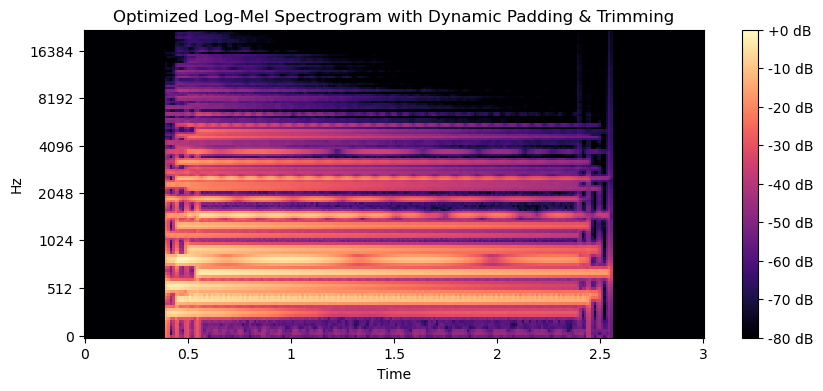

In [ ]:
import IPython.display
for index, row in train_dataset.iterrows():
    if index == 1:
        break
    file_path = Path('./Dataset/Audio_Files/'+str(row['New']))
    log_mel_spec, sr = get_log_mel_spectrogram(file_path, target_duration=3)

    # Plot Log-Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Optimized Log-Mel Spectrogram with Dynamic Padding & Trimming")
    plt.show()
    

Dataset/Audio_Files/1725_.wav


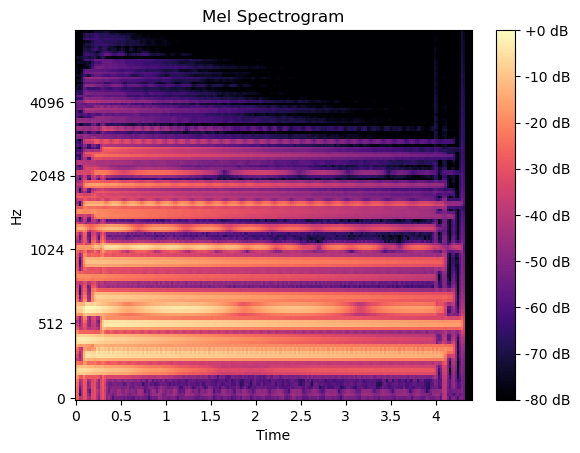

In [11]:
for index, row in train_dataset.iterrows():
    if index == 1:
        break
    file_path = Path('./Dataset/Audio_Files/'+str(row['New']))
    print(file_path)
    y, sr = librosa.load(file_path, sr=None)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512, fmax=8000)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
    plt.title('Mel Spectrogram');
    plt.colorbar(format='%+2.0f dB');

In [ ]:
label_encoder = preprocessing.LabelEncoder()
train_dataset['label'] = label_encoder.fit_transform(train_dataset['Classification'])
train_dataset.head()

,New,Classification,label
0,1725_.wav,Major,0
1,1659_.wav,Minor,1
2,2029_.wav,Major,0
3,2093_.wav,Minor,1
4,1661_.wav,Major,0


In [ ]:
import torch
class AudioClassification(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.data['label'] = label_encoder.fit_transform(self.data['Classification'])
    def __getitem__(self, index):
        audio_file_path = self.data.iloc[index]['New']
        audio_file_path = Path('./Dataset/Audio_Files/'+str(audio_file_path))
        label = torch.tensor(self.data.iloc[index]['label'])
        y,sr = librosa.load(audio_file_path)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr)
        # print(melspec.shape)
        y_left          = 128 - melspec.shape[1]
        padded_mel      = np.pad(melspec, ((0,0), (0,y_left) ), mode='constant', constant_values=0)
        log_S           = librosa.power_to_db(padded_mel, ref=np.max)
        print(audio_file_path, label, log_S.shape)
        # print(self.data.iloc[index])
        return {
            'input_ids':torch.tensor(log_S),
            'labels':label
        }
    def __len__(self):
        return len(self.data)
        

In [58]:
%%time
data = AudioClassification(train_csv)
data.__getitem__(2)
data.__len__()

Dataset/Audio_Files/2029_.wav 0 (128, 128)
CPU times: user 6.65 ms, sys: 2.04 ms, total: 8.69 ms
Wall time: 5.92 ms


678

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, loss, d_in, d_out):
        pass
    def forward(self, input_ids, labels):
        return {'loss':loss, 'logits': logits}